In [ ]:
!pip install transformers datasets evaluate accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.6 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer
from datasets import load_dataset
import evaluate
from matplotlib import pyplot as plt

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [ ]:
dataset = load_dataset("imagefolder", data_dir="/kaggle/input/brain-tumor-mri-dataset/Training")

Resolving data files:   0%|          | 0/5712 [00:00<?, ?it/s]

In [ ]:
dataset["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 'label': 0}

In [ ]:
split_dataset = dataset["train"].train_test_split(test_size=0.1)

dataset["train"] = split_dataset["train"]
dataset["validation"] = split_dataset["test"]

In [ ]:
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

In [ ]:
from PIL import Image
import torch

def transform(example):

    image = example["image"]
    for i in range(len(image)):
      if image[i].mode != "RGB":
         image[i] = image[i].convert("RGB")


    inputs = processor(images=image, return_tensors="pt")


    inputs = {k: v.squeeze(0) for k, v in inputs.items()}
    inputs["labels"] = example["label"]
    return inputs

In [ ]:
prepared_ds = dataset.with_transform(transform)

In [ ]:
num_labels = dataset["train"].features["label"].num_classes
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=num_labels
)
print(num_labels)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


4


In [ ]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    return metric.compute(predictions=preds, references=labels)

In [ ]:
training_args = TrainingArguments(
    output_dir="./vit-finetuned",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=10,
    learning_rate=5e-5,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    report_to=[],
    remove_unused_columns=False
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.080000,0.141903,0.958963
2,0.047300,0.082152,0.982721
3,0.012700,0.073567,0.984881
4,0.009400,0.074412,0.982721
5,0.005100,0.062768,0.989201
6,0.004000,0.059387,0.989201
7,0.003300,0.060878,0.989201
8,0.002900,0.060429,0.989201
9,0.002700,0.060505,0.989201
10,0.002600,0.060588,0.989201


TrainOutput(global_step=2610, training_loss=0.050116020403231466, metrics={'train_runtime': 1909.4414, 'train_samples_per_second': 21.802, 'train_steps_per_second': 1.367, 'total_flos': 3.226049354738811e+18, 'train_loss': 0.050116020403231466, 'epoch': 10.0})

In [ ]:
test_ds=load_dataset("imagefolder", data_dir="/kaggle/input/brain-tumor-mri-dataset/Testing")
prepared_test_ds = test_ds.with_transform(transform)
prepared_test_ds

Resolving data files:   0%|          | 0/1311 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1311
    })
})

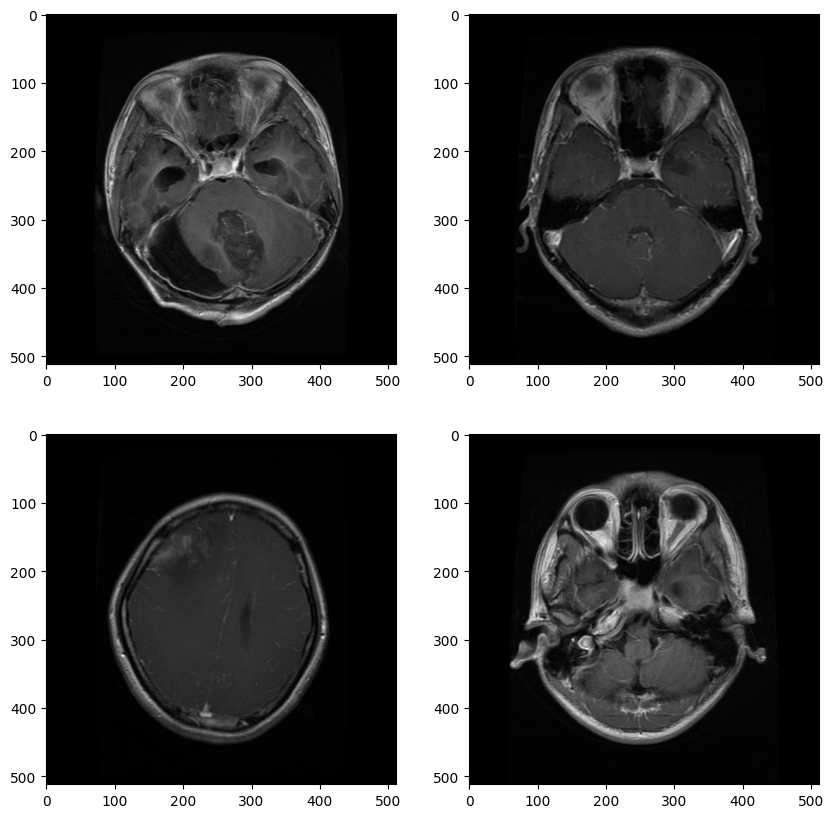

In [ ]:
plt.figure(figsize=(10,10))

for i in range(4):
  image=test_ds["train"][i]["image"]
  image=image.convert("RGB")
  plt.subplot(2,2,i+1)
  plt.imshow(test_ds["train"][i]["image"])



In [ ]:
result=trainer.predict(test_dataset=prepared_test_ds["train"])

In [ ]:
print(result)

PredictionOutput(predictions=array([[ 4.678452 , -1.6945657, -1.6701441, -1.7700595],
       [ 4.66589  , -1.7331634, -1.7295138, -1.7002898],
       [ 4.7072506, -1.627379 , -1.6778322, -1.8321006],
       ...,
       [-1.7649561, -1.2132102, -1.6577593,  4.842092 ],
       [-1.5640221, -1.4777571, -1.610255 ,  4.8077497],
       [-1.6210414, -1.5179094, -1.5336523,  4.8599224]], dtype=float32), label_ids=array([0, 0, 0, ..., 3, 3, 3]), metrics={'test_loss': 0.034867335110902786, 'test_accuracy': 0.9938977879481312, 'test_runtime': 25.2823, 'test_samples_per_second': 51.855, 'test_steps_per_second': 3.243})


In [ ]:
# so test accuracy is (0.9938) !!!